In [1]:
import warnings
import itertools
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima

In [2]:
df = pd.read_csv('data_inflasi.csv', sep=';')
df

,Bulan,Inflasi
0,2011-01,0.0702
1,2011-02,0.0684
2,2011-03,0.0665
3,2011-04,0.0616
4,2011-05,0.0598
...,...,...
151,2023-08,0.0327
152,2023-09,0.0228
153,2023-10,0.0256
154,2023-11,0.0286


In [3]:
print(df.dtypes)

Bulan       object
Inflasi    float64
dtype: object


In [4]:
#change to datetimeindex
datetimeindex = pd.to_datetime([f'{m_y.split("-")[0]}-{m_y.split("-")[1]}-01' for m_y in df['Bulan']])

In [5]:
df['Bulan'] = datetimeindex

In [6]:
df = df.set_index('Bulan')
df.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Bulan', length=156, freq=None)

In [7]:
y = df['Inflasi'].resample('MS').mean()

In [8]:
y['2011':]

Bulan
2011-01-01    0.0702
2011-02-01    0.0684
2011-03-01    0.0665
2011-04-01    0.0616
2011-05-01    0.0598
               ...  
2023-08-01    0.0327
2023-09-01    0.0228
2023-10-01    0.0256
2023-11-01    0.0286
2023-12-01    0.0261
Freq: MS, Name: Inflasi, Length: 156, dtype: float64

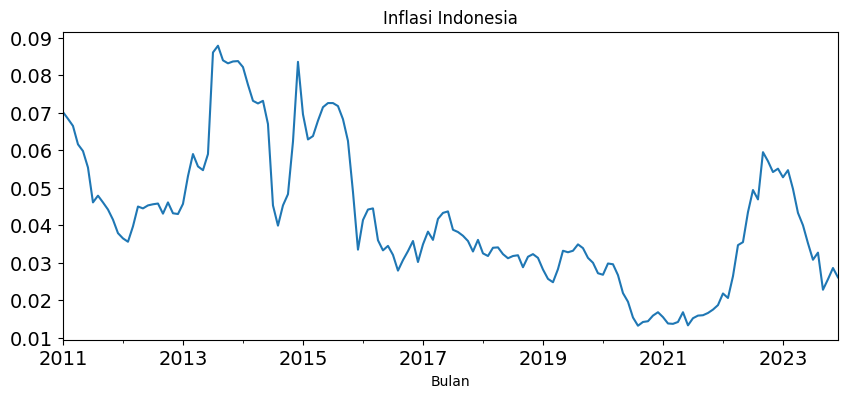

In [9]:
y.plot(figsize=(10, 4), title='Inflasi Indonesia', fontsize=14)
plt.show()

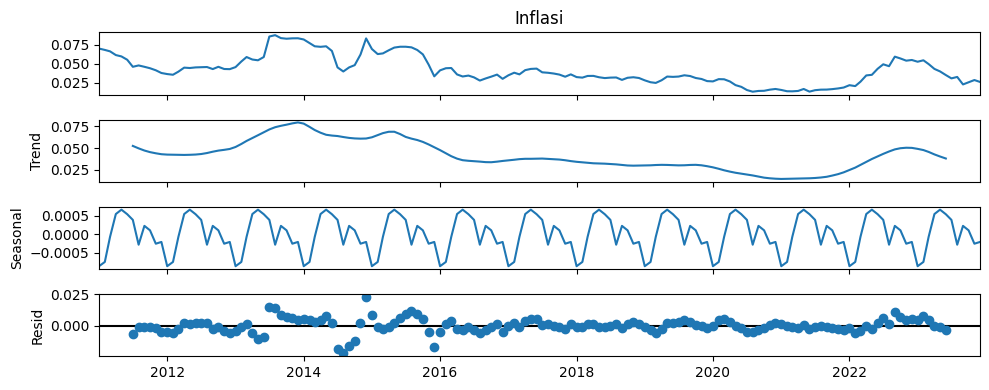

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [16]:
model = pmdarima.ARIMA(order=(1, 0, 1), 
                       seasonal_order=(0, 0, 0, 12))
results = model.fit(y)

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 602.441
Date:                Wed, 28 May 2025   AIC                          -1196.883
Time:                        01:24:11   BIC                          -1184.683
Sample:                    01-01-2011   HQIC                         -1191.928
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.189      0.234      -0.002       0.006
ar.L1          0.9443      0.038     24.557      0.000       0.869       1.020
ma.L1          0.2773      0.075      3.712      0.0

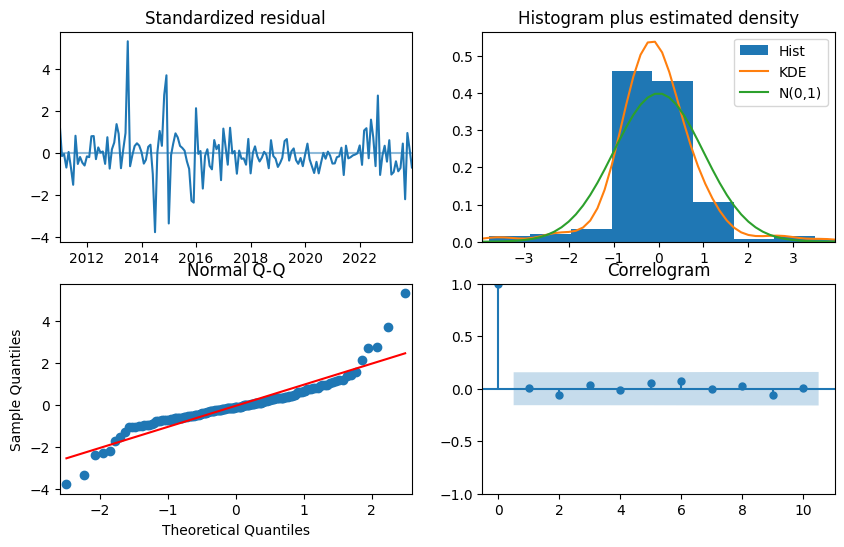

In [50]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

In [45]:
train = y['2011-01-01':'2022-12-01']
test = y['2023-01-01':]

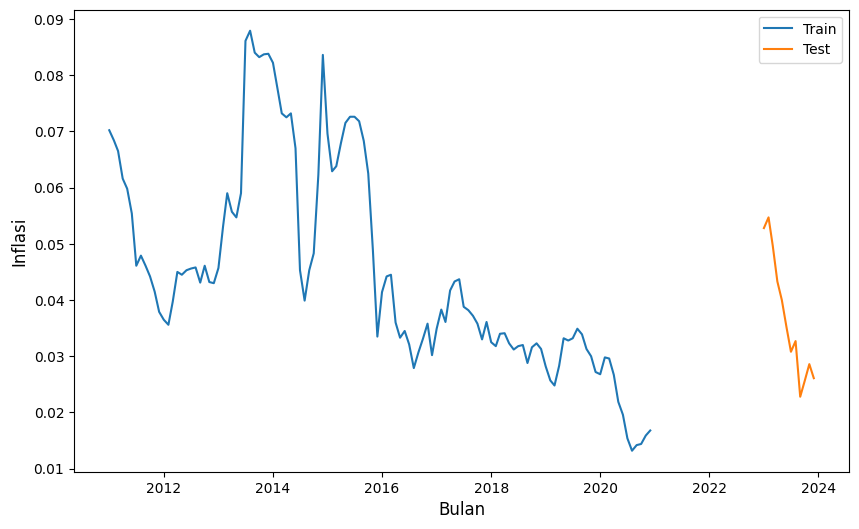

In [49]:
# Plot train and test series on the same plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Inflasi', fontsize=12)
plt.legend()
plt.show()

c:\Users\YOGA\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


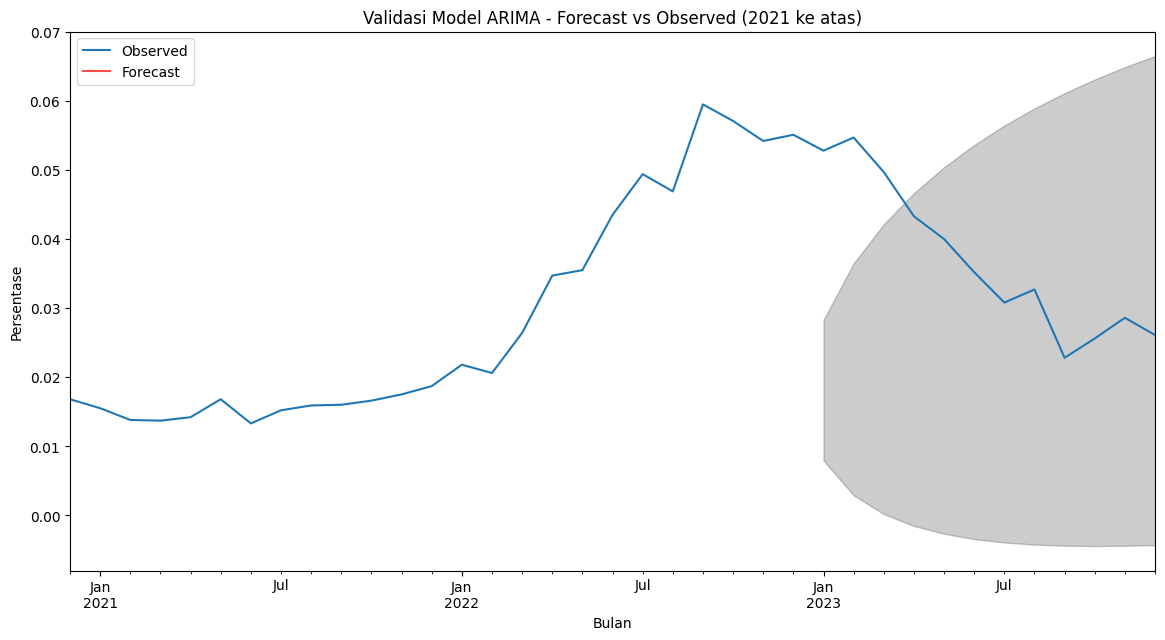

In [47]:
train = y[:'2020-12-01']
test = y['2023-01-01':]

# Fit model pada data latih
model = pm.ARIMA(order=(1, 0, 1), seasonal_order=(0, 0, 0, 12), seasonal=True, m=12)
model.fit(train)

# Prediksi sebanyak panjang data test
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Plot hasil
fig, ax = plt.subplots(figsize=(14, 7))

# Plot data observasi (gabungan train dan test)
y['2020-12-01':].plot(ax=ax, label='Observed')

# Plot hasil prediksi
forecast_index = test.index
pd.Series(forecast, index=forecast_index).plot(ax=ax, label='Forecast', color='r', alpha=0.7)

# Plot confidence interval
ax.fill_between(forecast_index,
                conf_int[:, 0],
                conf_int[:, 1],
                color='k', alpha=0.2)

# Label dan legenda
ax.set_xlabel('Bulan')
ax.set_ylabel('Persentase')
plt.title('Validasi Model ARIMA - Forecast vs Observed (2021 ke atas)')
plt.legend()
plt.show()

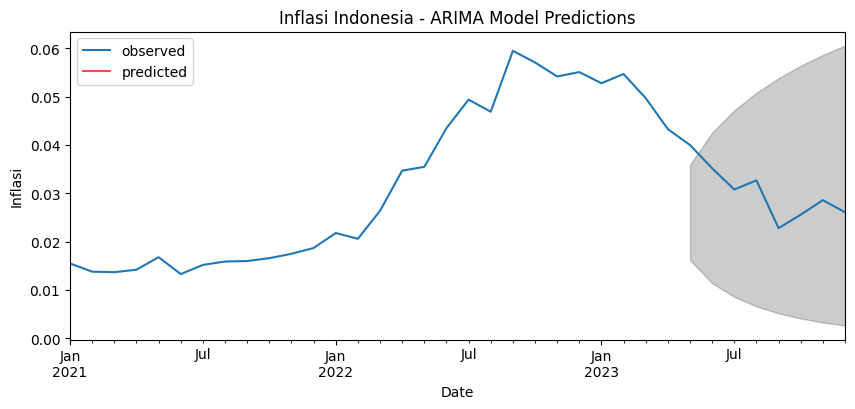

In [48]:
# plot predictions and observed values for ARIMA model using pmdarima
forecast, conf_int = results.predict(n_periods=len(y['2023-05-01':]), return_conf_int=True)
forecast_index = y['2023-05-01':].index

ax = y['2021':].plot(label='observed', figsize=(10, 4))
pd.Series(forecast, index=forecast_index).plot(ax=ax, label='predicted', alpha=.7, color='r')
ax.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Inflasi')
plt.legend()
plt.title('Inflasi Indonesia - ARIMA Model Predictions')
plt.show()

In [ ]:
# plot predictions and observed values Sarima model using statsmodels
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_conf = pred.conf_int()
ax = y['2011':].plot(label='observed', figsize=(10, 4))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7, color='r')
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1], 
                color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Inflasi')
plt.legend()
plt.title('Inflasi Indonesia - SARIMA Model Predictions')
plt.show()

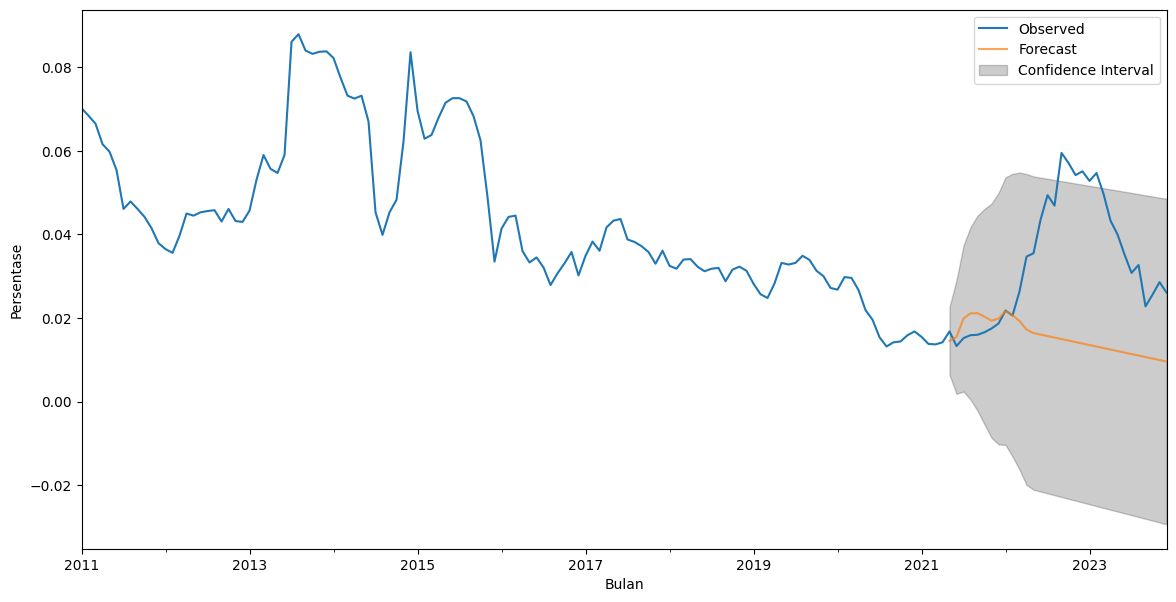

In [43]:
# Plot the observed values and forecast for the test period
ax = y.plot(label='Observed', figsize=(14, 7))
forecast_series.plot(ax=ax, label='Forecast', alpha=0.7)

# Plot confidence intervals
ax.fill_between(
    test.index,
    conf_int[:, 0],
    conf_int[:, 1],
    color='k',
    alpha=0.2,
    label='Confidence Interval'
)

ax.set_xlabel('Bulan')
ax.set_ylabel('Persentase')
plt.legend()
plt.show()

In [30]:
# 80% training, 20% testing
train_size = int(len(y) * 0.8)
train = y[:train_size]
test = y[train_size:]

print(f"Jumlah data training: {len(train)}")
print(f"Jumlah data testing: {len(test)}")

Jumlah data training: 124
Jumlah data testing: 32


In [42]:
forecast_periods = len(test)
forecast, conf_int = model.predict(n_periods=forecast_periods, return_conf_int=True)
forecast_series = pd.Series(forecast, index=test.index)

In [33]:
forecasts = model.predict(n_periods=len(test))
print(forecasts)

2021-05-01    0.014525
2021-06-01    0.015492
2021-07-01    0.019902
2021-08-01    0.021133
2021-09-01    0.021153
2021-10-01    0.020343
2021-11-01    0.019368
2021-12-01    0.019869
2022-01-01    0.021662
2022-02-01    0.020677
2022-03-01    0.019274
2022-04-01    0.017266
2022-05-01    0.016408
2022-06-01    0.016049
2022-07-01    0.015691
2022-08-01    0.015333
2022-09-01    0.014975
2022-10-01    0.014617
2022-11-01    0.014259
2022-12-01    0.013900
2023-01-01    0.013542
2023-02-01    0.013184
2023-03-01    0.012826
2023-04-01    0.012468
2023-05-01    0.012110
2023-06-01    0.011751
2023-07-01    0.011393
2023-08-01    0.011035
2023-09-01    0.010677
2023-10-01    0.010319
2023-11-01    0.009961
2023-12-01    0.009602
Freq: MS, dtype: float64


ValueError: x and y must have same first dimension, but have shapes (141,) and (32,)

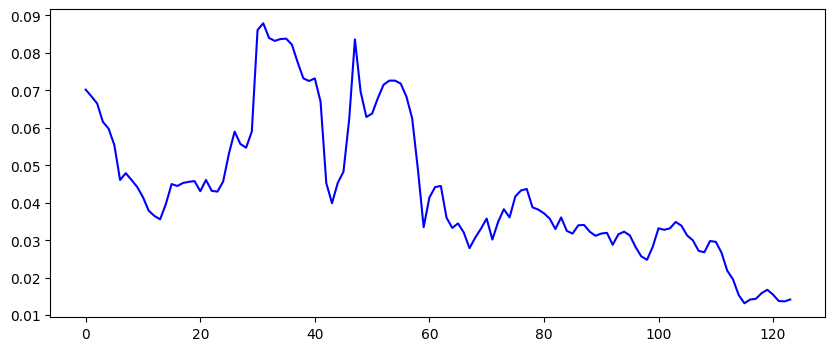

In [34]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:124], train, c='blue')
plt.plot(x[15:], forecasts, c='green')
plt.show()

In [ ]:
# import pmdarima as pm

# model = pm.auto_arima(train,
#                       start_p=1, start_q=1,
#                       max_p=5, max_q=5,
#                       m=12, # monthly data
#                       seasonal=True,
#                       d=None, D=None,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)

# print(model.summary())

In [ ]:
# p = d= q = range(0,2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}12'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}12'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}12'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}12'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)
#             results = mod.fit()
            
#             print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [ ]:
# mod = sm.tsa.statespace.SARIMAX(y,
#                                 order=(1, 0, 1),
#                                 seasonal_order=(1, 0, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results = mod.fit()
# print(results.summary())